<a href="https://colab.research.google.com/github/MikeKwak/Gender-Age-Prediction-Model/blob/main/AgeGenderPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!git clone https://github.com/MikeKwak/Gender-Age-Prediction-Model
%cd Gender-Age-Prediction-Model

Cloning into 'Gender-Age-Prediction-Model'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (26/26), 1.29 MiB | 21.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/age_and_gender_detection/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model


In [16]:
# Downloading pretrained data and unzipping it
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/age_and_gender_detection/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/Gender-Age-Prediction-Model/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 262MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [17]:
# Import required libraries and modules
import cv2 as cv
import math
import time
# Special function for Google Colab to display OpenCV images
from google.colab.patches import cv2_imshow

# Function to detect faces in a given frame using a pre-trained model
def getFaceBox(net, frame, conf_threshold=0.7):
    # Copy the original frame for further processing
    frameOpencvDnn = frame.copy()
    # Get frame dimensions
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    # Convert image to blob (Binary Large Object) for DNN processing
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    # Set the blob as input to the network
    net.setInput(blob)
    # Forward pass to get detections
    detections = net.forward()
    bboxes = [] # List to store bounding boxes of detected faces
    # Iterate over detections to extract bounding boxes
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # If detection confidence is greater than threshold, process it
        if confidence > conf_threshold:
            # Extract bounding box coordinates
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            # Append the bounding box to the list
            bboxes.append([x1, y1, x2, y2])
            # Draw bounding box on the frame
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

# Paths to the pre-trained face detection model files
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

# Paths to the age prediction model files
ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

# Paths to the gender prediction model files
genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

# Mean values for RGB channels, used for normalization
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# Lists of age groups and genders the models can predict
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load pre-trained models into memory
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

# Padding to be used when extracting face region for better prediction
padding = 20

# Function to detect age and gender of faces in a given frame
def age_gender_detector(frame):
    # Start timing the function for performance evaluation (optional)
    t = time.time()
    # Detect faces and get bounding boxes
    frameFace, bboxes = getFaceBox(faceNet, frame)
    # Process each detected face for age and gender prediction
    for bbox in bboxes:
        # Extract face region with padding
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]
        # Convert face image to blob
        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        # Predict gender
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # Predict age
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        # Annotate frame with predicted age and gender
        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    # Return the annotated frame
    return frameFace


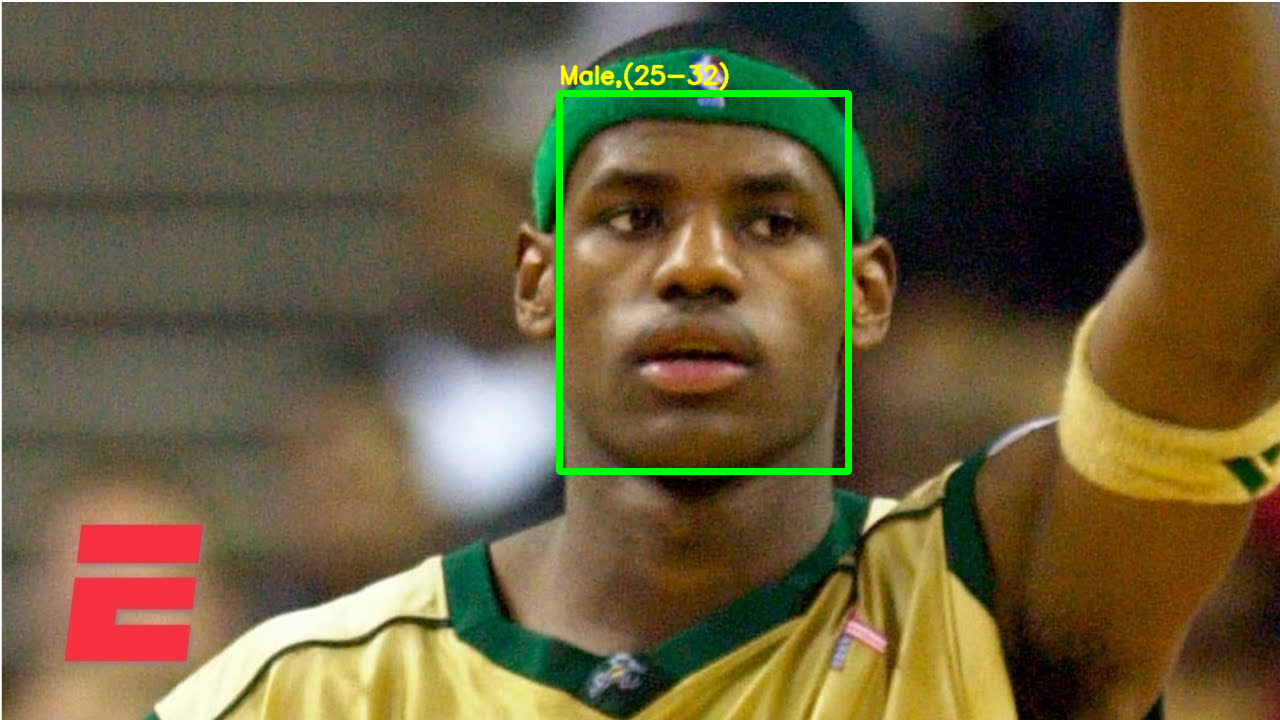

In [18]:
input = cv.imread("lebron_young.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

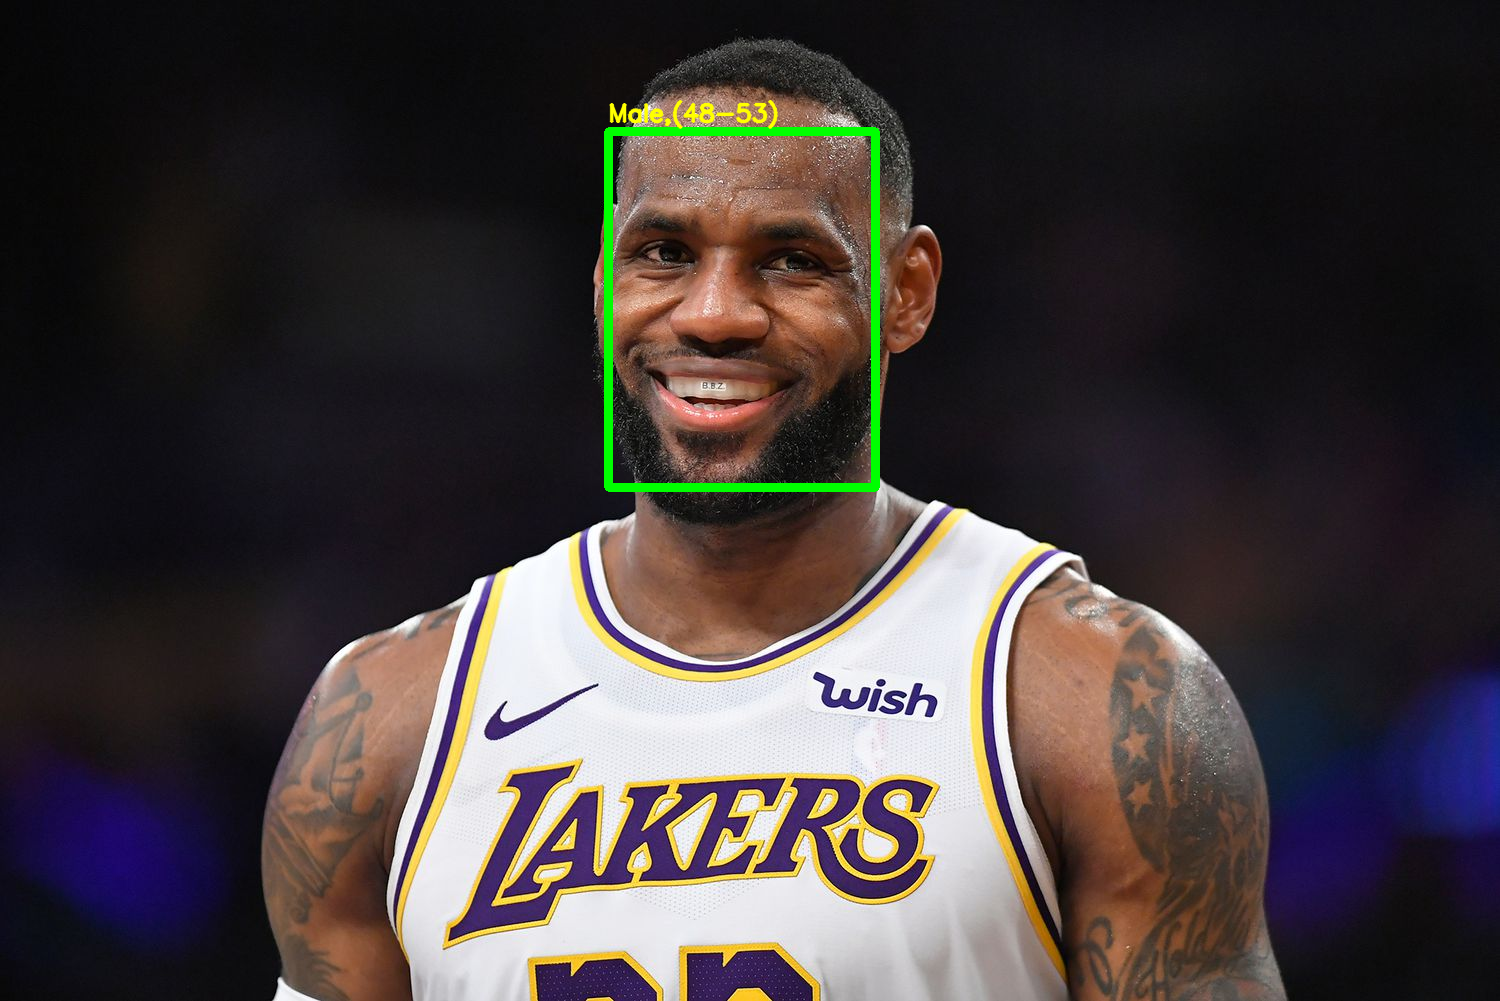

In [22]:
input = cv.imread("lebron_old.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

In [ ]:
import cv2
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")